<a href="https://colab.research.google.com/github/karu-bee/tutorials/blob/master/AffineVAE_220525_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11501568/11490434 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 vae (VAE)                   ((None, 10),              964139    
                              (None, 28, 28, 1),                 
                              (None, 16, 2))                     
                                                                 
Total params: 964,139
Trainable params: 964,139
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
59/59 [==============================] - 36s 469ms/step - loss: 0.1033 - vae_loss: 2.2977 - vae_1_loss: 0.1007 

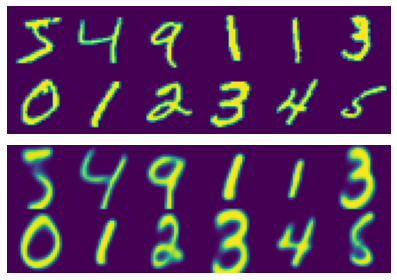

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt


class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = tf.keras.layers.Dense(512, activation="relu")
        self.layer2 = tf.keras.layers.Dense(512, activation="relu")
        self.layer3m = tf.keras.layers.Dense(16)
        self.layer3v = tf.keras.layers.Dense(16, activation="softplus")

    def call(self, x, *args, **kwargs):
        x = self.layer1(x)
        x = self.layer2(x)
        m = self.layer3m(x)
        v = self.layer3v(x)
        return [m, v]


class Decoder(tf.keras.layers.Layer):
    def __init__(self, h, w):
        super(Decoder, self).__init__()
        self.layer1 = tf.keras.layers.Dense(512, activation="relu")
        self.layer2 = tf.keras.layers.Dense(512, activation="relu")
        self.layer3 = tf.keras.layers.Dense(1, activation="sigmoid")
        ys = np.linspace(-1, 1, h)
        xs = np.linspace(-1, 1, w)
        uv = np.zeros((h, w, 2))
        for iy in range(0, h):
            for ix in range(0, w):
                uv[iy, ix] = np.array([ys[iy], xs[ix]])
        self.uv = tf.constant(uv, dtype=tf.float32)  # (h, w, 2)
        self.uv = tf.expand_dims(self.uv, axis=0)  # (1, h, w, 2)
        self.apply_transform = True

    def call(self, z, *args, **kwargs):
        p = z[:, -6:]  # transform params

        z = z[:, :-6]
        z = z[..., tf.newaxis, tf.newaxis]
        z = tf.transpose(z, (0, 2, 3, 1))
        uv = self.uv + tf.zeros_like(z[:, :, :, 0:1])  # broadcast
        if self.apply_transform:
            p_mat = tf.reshape(p, (-1, 2, 3))
            p_zeros = tf.zeros_like(p_mat[:, 0:1, :])
            p_mat = tf.concat([p_mat, p_zeros], axis=-2)
            p_mat = 0.1 * p_mat + tf.eye(3)
            uv1 = tf.ones_like(uv[:, :, :, 0:1])
            uv3 = tf.concat([uv, uv1], axis=-1)
            uv = tf.keras.backend.batch_dot(uv3, p_mat)[:, :, :, 0:2]

        z = tf.tile(z, (1, uv.shape[1], uv.shape[2], 1))  # broadcast
        uvz = tf.concat([uv, z], axis=-1)
        uvz = tf.reshape(uvz, (-1, uvz.shape[-1]))  # (batch * h * w, z + 2)

        x = self.layer1(uvz)
        x = self.layer2(x)
        x = self.layer3(x)
        x = tf.reshape(x, (-1, uv.shape[1], uv.shape[2], 1))
        return x


class Predictor(tf.keras.layers.Layer):
    def __init__(self):
        super(Predictor, self).__init__()
        self.layer1 = tf.keras.layers.Dense(512, activation="relu")
        self.layer2 = tf.keras.layers.Dense(10, activation="softmax")

    def call(self, x, *args, **kwargs):
        x = self.layer1(x)
        x = self.layer2(x)
        return x


class VAE(tf.keras.layers.Layer):
    def __init__(self, name="vae"):
        super(VAE, self).__init__(name=name)
        self.encoder = Encoder()
        self.decoder = Decoder(28, 28)
        self.predictor = Predictor()

    def call(self, x, *args, **kwargs):
        m, v = self.encoder(x)
        dist = tfp.distributions.Normal(m, v)
        z = dist.sample([1])
        z = z[0, :, :]
        y = self.decoder(z)
        mv = tf.stack([m, v], axis=-1)

        pred = self.predictor(z[:, :-1])  # exclude transform parameter
        return pred, y, mv


if __name__ == '__main__':
    tf.random.set_seed(1234)

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        strategy = tf.distribute.get_strategy()

    dataset = tf.keras.datasets.mnist
    (train_images, train_labels), (test_images, test_labels) = dataset.load_data()

    epochs = 50
    batch_size = 1000

    train_images = train_images / 255.0
    test_images = test_images / 255.0
    if len(train_images.shape) == 3:
        train_images = np.expand_dims(train_images, axis=-1)
        test_images = np.expand_dims(test_images, axis=-1)

    def prepare_model():
        def kl_d(y_ideal, y_pred):
            mu = y_pred[:, :, 0]
            var = y_pred[:, :, 1]
            dist_pred = tfp.distributions.Normal(mu, var + 1e-8)
            dist_standard = tfp.distributions.Normal(0, 1)
            loss = tfp.distributions.kl_divergence(dist_pred, dist_standard) / tf.cast(tf.size(mu), dtype=tf.float32)
            return loss

        vae = VAE()
        inputs = tf.keras.layers.Input(train_images[0].shape)
        x = tf.keras.layers.Flatten()(inputs)
        x = vae(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)

        model.summary()
        model.compile(optimizer="adam",
                      loss=["sparse_categorical_crossentropy", "mse", kl_d],
                      metrics={"vae": ["accuracy"]},
                      loss_weights=[1e-3, 1, 5])  # heuristic
        return model, vae


    with strategy.scope():
        model, vae = prepare_model()

    model.fit(train_images, [train_labels, train_images, train_images], epochs=epochs, validation_split=0.02, batch_size=batch_size)
    model.evaluate(test_images, [test_labels, test_images, test_images])

    vae.decoder.apply_transform = False
    x = train_images[0:12]
    y = vae(tf.keras.layers.Flatten()(x))[1].numpy()

    fig, ax = plt.subplots(2, 1, tight_layout=True)
    x = np.transpose(x.reshape((-1, 2, 28, 28)), (1, 2, 0, 3)).reshape((56, -1))
    y = np.transpose(y.reshape((-1, 2, 28, 28)), (1, 2, 0, 3)).reshape((56, -1))

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].imshow(x)
    ax[1].imshow(y)
    plt.show()